# LDA para o Currículo Referência de Minas Gerais para Educação Infantil (EI) e Ensino Fundamental (EF) / Com exclusão das top 30 palavras + palavras dos tópicos da BNCC:


## Importação das bibliotecas:

In [1]:
# Para ler o PDF:
import PyPDF2

# Para analisar o layout do PDF e extrair o texto:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

# Para extrair textos de tabelas em PDF:
import pdfplumber

# Para extrair as imagens dos PDFs:
from PIL import Image
from pdf2image import convert_from_path

# Para fazer Reconhecimento Ótico de Caracteres (OCR) para extrair textos das imagens:
import pytesseract

# Para remover os arquivos adicionais criados:
import os

# Para manipulação e análise dos dados:
import pandas as pd
import numpy as np
from collections import Counter
import pickle

# Para acompanhar a execução dos códigos:
from tqdm import tqdm

# Para análise dos dados textuais:
import re
import nltk
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

# Para visualizações:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Download do modelo para língua portuguesa:
spacy.cli.download("pt_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [3]:
# Carregamento do modelo:
nlp = spacy.load('pt_core_news_lg')

## 1. Importação do corpus (stem) e retirada das top 30 palavras + palavras dos tópicos da BNCC:

In [4]:
# Abrir o arquivo no modo de leitura binária
with open("MG_stem.pkl", 'rb') as file:
    # Carregar o conteúdo do arquivo pickled
    df = pickle.load(file)

In [5]:
df

frases  \
0     ['Currículo Referência de Minas Gerais ', ' ',...   
1     É  preciso  que  se ', 'compreenda  a  noção  ...   
2     ', 'A Base Nacional Curricular Comum – BNCC: '...   
3                                       (BRASIL, 2017).   
4     ', 'Torna-se referência nacional para a formul...   
...                                                 ...   
4423  ['Currículo Referência de Minas Gerais ', ' ',...   
4424  ['Currículo Referência de Minas Gerais ', ' ',...   
4425  ['Currículo Referência de Minas Gerais ', ' ',...   
4426  ['Currículo Referência de Minas Gerais ', ' ',...   
4427  ['Currículo Referência de Minas Gerais ', ' ',...   

                                          Preprocessado  \
0     [curriculo, referencia, minas, gerais, curricu...   
1     [preciso, que, compreenda, nocao, curriculo, b...   
2     [base, nacional, curricular, comum, bncc, docu...   
3                                              [brasil]   
4     [torna, referencia, nacional, para, formulacao...   
...                                                 ...   
4423  [curriculo, referencia, minas, gerais, ano, un...   
4424  [curriculo, referencia, minas, gerais, ano, un...   
4425  [curriculo, referencia, minas, gerais, ano, un...   
4426  [curriculo, referencia, minas, gerais, ano, un...   
4427  [curriculo, referencia, minas, gerais, ano, un...   

                                          Sem_stopwords  \
0     [curriculo, referencia, minas, gerais, curricu...   
1     [preciso, compreenda, nocao, curriculo, base, ...   
2     [base, nacional, curricular, comum, bncc, docu...   
3                                              [brasil]   
4     [torna, referencia, nacional, formulacao, curr...   
...                                                 ...   
4423  [curriculo, referencia, minas, gerais, ano, un...   
4424  [curriculo, referencia, minas, gerais, ano, un...   
4425  [curriculo, referencia, minas, gerais, ano, un...   
4426  [curriculo, referencia, minas, gerais, ano, un...   
4427  [curriculo, referencia, minas, gerais, ano, un...   

                                                   Stem  
0     [curricul, referenc, min, geral, curricul, bnc...  
1     [precis, compreend, noca, curricul, bas, nacio...  
2     [bas, nacion, curricul, comum, bncc, document,...  
3                                              [brasil]  
4     [torn, referenc, nacion, formulaca, curricul, ...  
...                                                 ...  
4423  [curricul, referenc, min, geral, ano, unidad, ...  
4424  [curricul, referenc, min, geral, ano, unidad, ...  
4425  [curricul, referenc, min, geral, ano, unidad, ...  
4426  [curricul, referenc, min, geral, ano, unidad, ...  
4427  [curricul, referenc, min, geral, ano, unidad, ...  

[4428 rows x 4 columns]

In [6]:
def excluir_strings_especificas(dataframe, coluna, strings_para_excluir):
    """
    Remove as strings específicas da coluna 'coluna' do dataframe 'dataframe'.
    
    Parâmetros:
    - dataframe: O dataframe pandas.
    - coluna: Nome da coluna que contém as listas de strings.
    - strings_para_excluir: Lista de strings que devem ser removidas de cada lista na coluna.
    
    Retorna:
    Um novo dataframe com as strings removidas.
    """
    # Função para aplicar em cada linha da coluna
    def remover_strings(lista_original):
        nova_lista = [item.strip() for item in lista_original if item.strip() not in strings_para_excluir]
        return nova_lista

    # Aplicar a função em cada linha da coluna
    dataframe[coluna] = dataframe[coluna].apply(remover_strings)

    return dataframe

In [7]:
strings_BNCC = ['difer',
                'text',
                'lingu',
                'conhec',
                'pra',
                'cult',
                'ano',
                'analis',
                'soc',
                'ensin',
                'habil',
                'identific',
                'produca',
                'objet',
                'desenvolv',
                'camp',
                'estud',
                'etc',
                'divers',
                'natur',
                'uso',
                'vid',
                'context',
                'leit',
                'fundament',
                'brasil',
                'process',
                'educaca',
                'espac',
                'utiliz',
                'religi',
                'mund',
                'are',
                'nacion',
                'lei',
                'basic',
                'disponi',
                'tecnolog',
                'problem',
                'envolv',
                'digit']

In [8]:
df = excluir_strings_especificas(df, 'Stem', strings_BNCC)

In [9]:
df

frases  \
0     ['Currículo Referência de Minas Gerais ', ' ',...   
1     É  preciso  que  se ', 'compreenda  a  noção  ...   
2     ', 'A Base Nacional Curricular Comum – BNCC: '...   
3                                       (BRASIL, 2017).   
4     ', 'Torna-se referência nacional para a formul...   
...                                                 ...   
4423  ['Currículo Referência de Minas Gerais ', ' ',...   
4424  ['Currículo Referência de Minas Gerais ', ' ',...   
4425  ['Currículo Referência de Minas Gerais ', ' ',...   
4426  ['Currículo Referência de Minas Gerais ', ' ',...   
4427  ['Currículo Referência de Minas Gerais ', ' ',...   

                                          Preprocessado  \
0     [curriculo, referencia, minas, gerais, curricu...   
1     [preciso, que, compreenda, nocao, curriculo, b...   
2     [base, nacional, curricular, comum, bncc, docu...   
3                                              [brasil]   
4     [torna, referencia, nacional, para, formulacao...   
...                                                 ...   
4423  [curriculo, referencia, minas, gerais, ano, un...   
4424  [curriculo, referencia, minas, gerais, ano, un...   
4425  [curriculo, referencia, minas, gerais, ano, un...   
4426  [curriculo, referencia, minas, gerais, ano, un...   
4427  [curriculo, referencia, minas, gerais, ano, un...   

                                          Sem_stopwords  \
0     [curriculo, referencia, minas, gerais, curricu...   
1     [preciso, compreenda, nocao, curriculo, base, ...   
2     [base, nacional, curricular, comum, bncc, docu...   
3                                              [brasil]   
4     [torna, referencia, nacional, formulacao, curr...   
...                                                 ...   
4423  [curriculo, referencia, minas, gerais, ano, un...   
4424  [curriculo, referencia, minas, gerais, ano, un...   
4425  [curriculo, referencia, minas, gerais, ano, un...   
4426  [curriculo, referencia, minas, gerais, ano, un...   
4427  [curriculo, referencia, minas, gerais, ano, un...   

                                                   Stem  
0     [curricul, referenc, min, geral, curricul, bnc...  
1     [precis, compreend, noca, curricul, bas, comum...  
2     [bas, curricul, comum, bncc, document, carat, ...  
3                                                    []  
4     [torn, referenc, formulaca, curricul, sistem, ...  
...                                                 ...  
4423  [curricul, referenc, min, geral, unidad, tema,...  
4424  [curricul, referenc, min, geral, unidad, tema,...  
4425  [curricul, referenc, min, geral, unidad, tema,...  
4426  [curricul, referenc, min, geral, unidad, tema,...  
4427  [curricul, referenc, min, geral, unidad, tema,...  

[4428 rows x 4 columns]

## 2. LDA:

In [10]:
# Criar o dicionário de palavras
dicionario = corpora.Dictionary(df['Stem'])

In [11]:
# Criar o corpus
corpus = [dicionario.doc2bow(text) for text in df['Stem']]

### Identificação do melhor valor para Coherence Score:

In [12]:
# Função para testar vários coherence scores e perplexities:

def compute_performance(dictionary, corpus, texts, limit, start, step):
    """
    Computa c_v coherence score para vários números de tópicos.

    Parâmetros:
    dicionário: dicionario;
    corpus: corpus;
    texts: lista de listas com as palavras pré-processadas do documento;
    limit: Máximo nº de tópicos;
    start: Nº de tópicos inicial;
    step: intervalo entre os nº de tópicos testados.

    Resultados:
    model_list: lista de modelos LDA.
    coherence_values: valores de coerência correspondentes ao modelo LDA com o respectivo nº de tópicos.
    """
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dicionario,
                         random_state=42,
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

In [13]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=102,
                                                                           step=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [11:39<00:00, 33.29s/it]


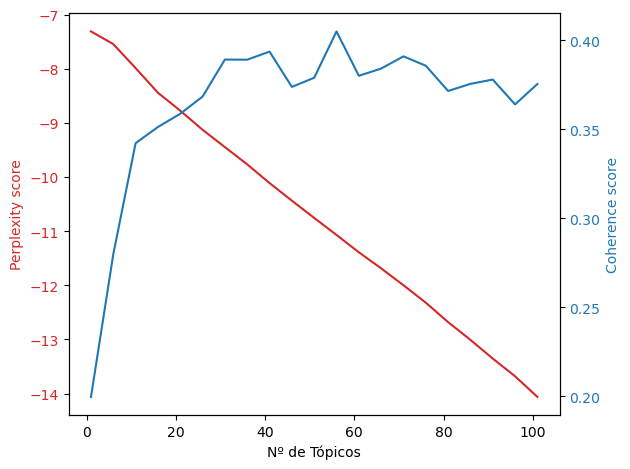

In [14]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=102; start=1; step=5;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('MG_2_Coherence Score_100 topicos.png')

plt.show()

In [15]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.1996  e valor de perplexidade de -7.31
A quantidade de tópicos = 6  tem um valor de coerência de  0.2798  e valor de perplexidade de -7.5448
A quantidade de tópicos = 11  tem um valor de coerência de  0.3422  e valor de perplexidade de -7.9884
A quantidade de tópicos = 16  tem um valor de coerência de  0.3512  e valor de perplexidade de -8.4432
A quantidade de tópicos = 21  tem um valor de coerência de  0.3587  e valor de perplexidade de -8.7749
A quantidade de tópicos = 26  tem um valor de coerência de  0.3683  e valor de perplexidade de -9.1273
A quantidade de tópicos = 31  tem um valor de coerência de  0.3891  e valor de perplexidade de -9.4479
A quantidade de tópicos = 36  tem um valor de coerência de  0.389  e valor de perplexidade de -9.767
A quantidade de tópicos = 41  tem um valor de coerência de  0.3936  e valor de perplexidade de -10.1117
A quantidade de tópicos = 46  tem um valor de coerência de  0.3738  e valor de

In [16]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=15,
                                                                           limit=41,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [13:46<00:00, 31.79s/it]


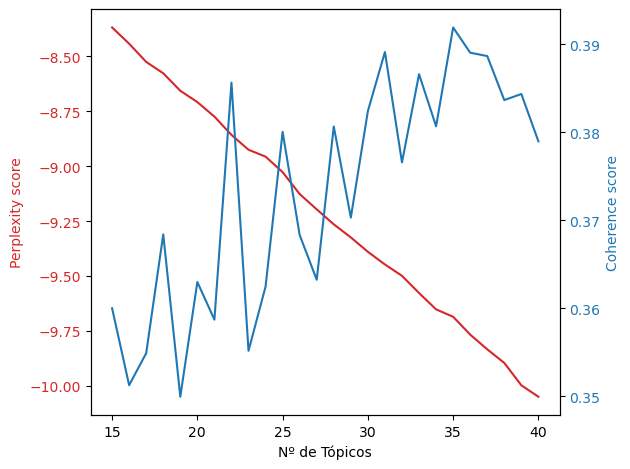

In [17]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=41; start=15; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('MG_2_Coherence Score_21 topicos.png')

plt.show()

In [18]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 15  tem um valor de coerência de  0.36  e valor de perplexidade de -8.3694
A quantidade de tópicos = 16  tem um valor de coerência de  0.3512  e valor de perplexidade de -8.4432
A quantidade de tópicos = 17  tem um valor de coerência de  0.3549  e valor de perplexidade de -8.5262
A quantidade de tópicos = 18  tem um valor de coerência de  0.3684  e valor de perplexidade de -8.5779
A quantidade de tópicos = 19  tem um valor de coerência de  0.3499  e valor de perplexidade de -8.6574
A quantidade de tópicos = 20  tem um valor de coerência de  0.363  e valor de perplexidade de -8.7089
A quantidade de tópicos = 21  tem um valor de coerência de  0.3587  e valor de perplexidade de -8.7749
A quantidade de tópicos = 22  tem um valor de coerência de  0.3856  e valor de perplexidade de -8.8581
A quantidade de tópicos = 23  tem um valor de coerência de  0.3552  e valor de perplexidade de -8.9258
A quantidade de tópicos = 24  tem um valor de coerência de  0.3625  e valor 

In [34]:
# Valor escolhido para coherence score foi 14 tópicos (coherence score = 0.5285):
# Número de tópicos
num_topicos = 22

In [35]:
# Inputar os dados e rodar o modelo LDA:
modelo_lda = LdaModel(corpus=corpus,
                      id2word=dicionario,
                      num_topics=num_topicos,
                      random_state=42,
                      per_word_topics=True)

In [36]:
# Imprimir os tópicos:
for topic_id in range(num_topicos):
    print(f"Topic {topic_id}: {modelo_lda.show_topic(topic_id)}")

Topic 0: [('val', 0.019855252), ('geral', 0.018088516), ('curricul', 0.017058715), ('min', 0.016131068), ('referenc', 0.014530766), ('sent', 0.011592717), ('sao', 0.010537129), ('artis', 0.010158444), ('literari', 0.009733608), ('sujeit', 0.009185724)]
Topic 1: [('crianc', 0.0141916955), ('experienc', 0.01341955), ('matriz', 0.012955702), ('hist', 0.012112576), ('aprendiz', 0.012068739), ('pequen', 0.011297849), ('independenc', 0.009105884), ('epistemolog', 0.008810664), ('logic', 0.008157217), ('nao', 0.007900875)]
Topic 2: [('unidad', 0.01830744), ('principi', 0.015359873), ('compreensa', 0.013128889), ('referenc', 0.012827259), ('etic', 0.012577805), ('geral', 0.011655699), ('curricul', 0.011217319), ('simbol', 0.011080377), ('min', 0.011043152), ('capac', 0.010161925)]
Topic 3: [('artis', 0.022926604), ('publ', 0.016412217), ('literari', 0.01628597), ('sao', 0.013389102), ('atuaca', 0.01320227), ('curricul', 0.0120503185), ('geral', 0.010832169), ('port', 0.010415399), ('intervenco

### Visualizações:

In [37]:
# Visualização dos tópicos:
visualizacao_BNCC = pyLDAvis.gensim_models.prepare(modelo_lda, corpus, dicionario, n_jobs=1)

In [39]:
# Salvar a visualização como um arquivo HTML:
pyLDAvis.save_html(visualizacao_BNCC, r"MG_2_visualizacao_BNCC_22_topicos.html"

SyntaxError: unexpected EOF while parsing (2305112677.py, line 2)

### Distribuição de palavras por frase:

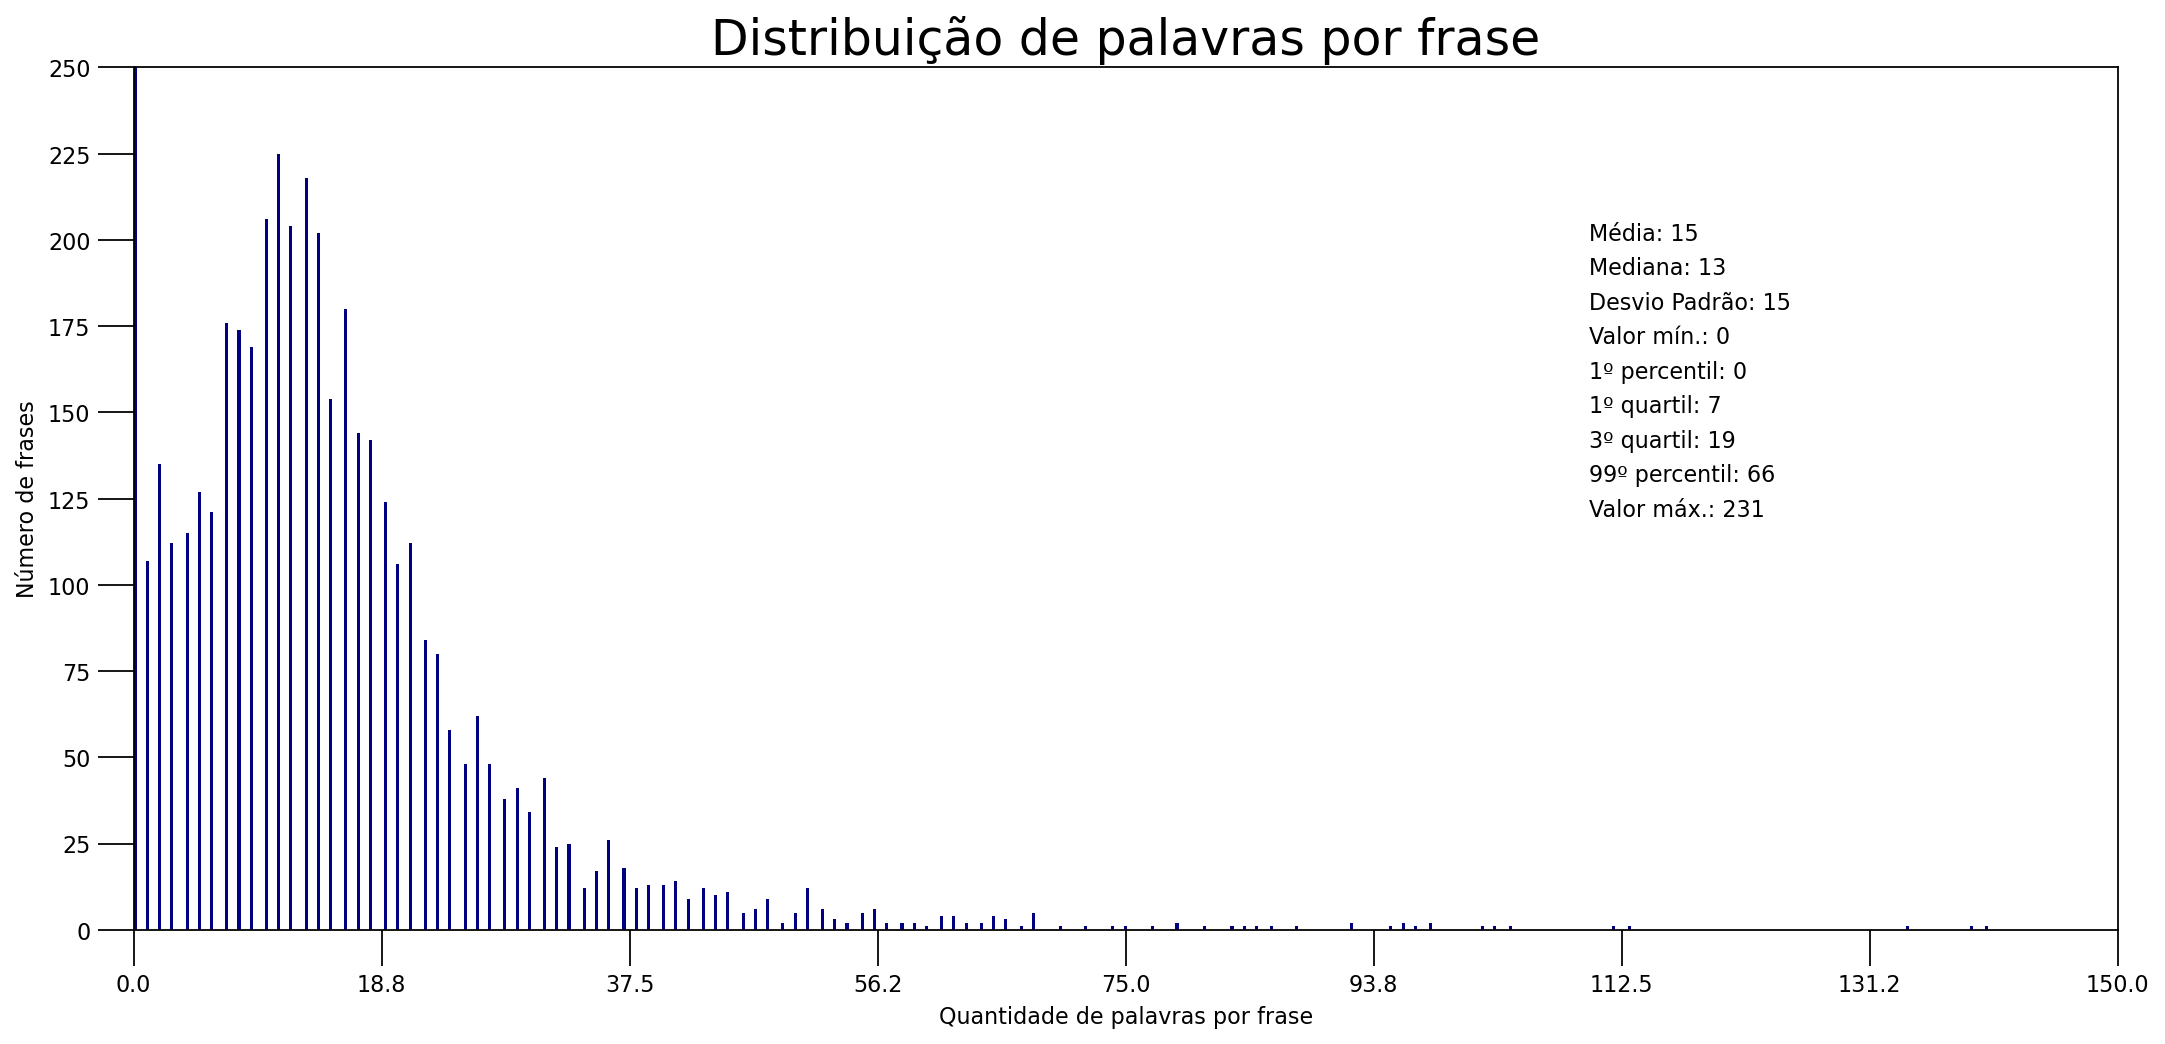

In [43]:
doc_lens = [len(d) for d in df['Stem']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(110, 200, "Média: " + str(round(np.mean(doc_lens))))
plt.text(110, 190, "Mediana: " + str(round(np.median(doc_lens))))
plt.text(110, 180, "Desvio Padrão: " + str(round(np.std(doc_lens))))
plt.text(110, 170, "Valor mín.: " + str(round(np.min(doc_lens))))
plt.text(110, 160, "1º percentil: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(110, 150, "1º quartil: " + str(round(np.quantile(doc_lens, q=0.25))))
plt.text(110, 140, "3º quartil: " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(110, 130, "99º percentil: " + str(round(np.quantile(doc_lens, q=0.99))))
plt.text(110, 120, "Valor máx.: " + str(round(np.max(doc_lens))))

plt.gca().set(xlim=(0, 150), ylim=(0, 250), ylabel='Número de frases', xlabel='Quantidade de palavras por frase')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,150,9))
plt.yticks(np.linspace(0,250,11))
plt.title('Distribuição de palavras por frase', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('MG_2_Distribuicao_de_palavras_por_frase.png')

plt.show()

### Frequência de palavras em todo o documento:

In [44]:
# Concatenar todas as strings em uma única lista de palavras:
palavras = [palavra for lista in df['Stem'].values for palavra in lista]

# Calcular a frequência das palavras:
freq_dist = FreqDist(palavras)

# Obter as palavras mais frequentes:
top30_palavras = freq_dist.most_common(30)

# Criar um DataFrame com as palavras e suas frequências:
top30_palavras_df = pd.DataFrame(top30_palavras, columns=['Palavra', 'Frequência'])

# Imprimir o DataFrame:
top30_palavras_df

Palavra  Frequência
0    curricul        1364
1       geral        1026
2         min        1018
3    referenc        1012
4      crianc         773
5    aprendiz         631
6      atuaca         597
7   experienc         475
8      unidad         428
9        tema         413
10      escol         369
11     escrit         356
12        nao         338
13       sent         334
14     pequen         329
15       oral         324
16        sao         311
17    situaco         305
18     direit         301
19       form         298
20     profes         291
21     relaco         273
22  construca         254
23       tamb         252
24    propost         250
25      brinc         247
26     import         243
27    trabalh         240
28      artis         240
29   reconhec         233

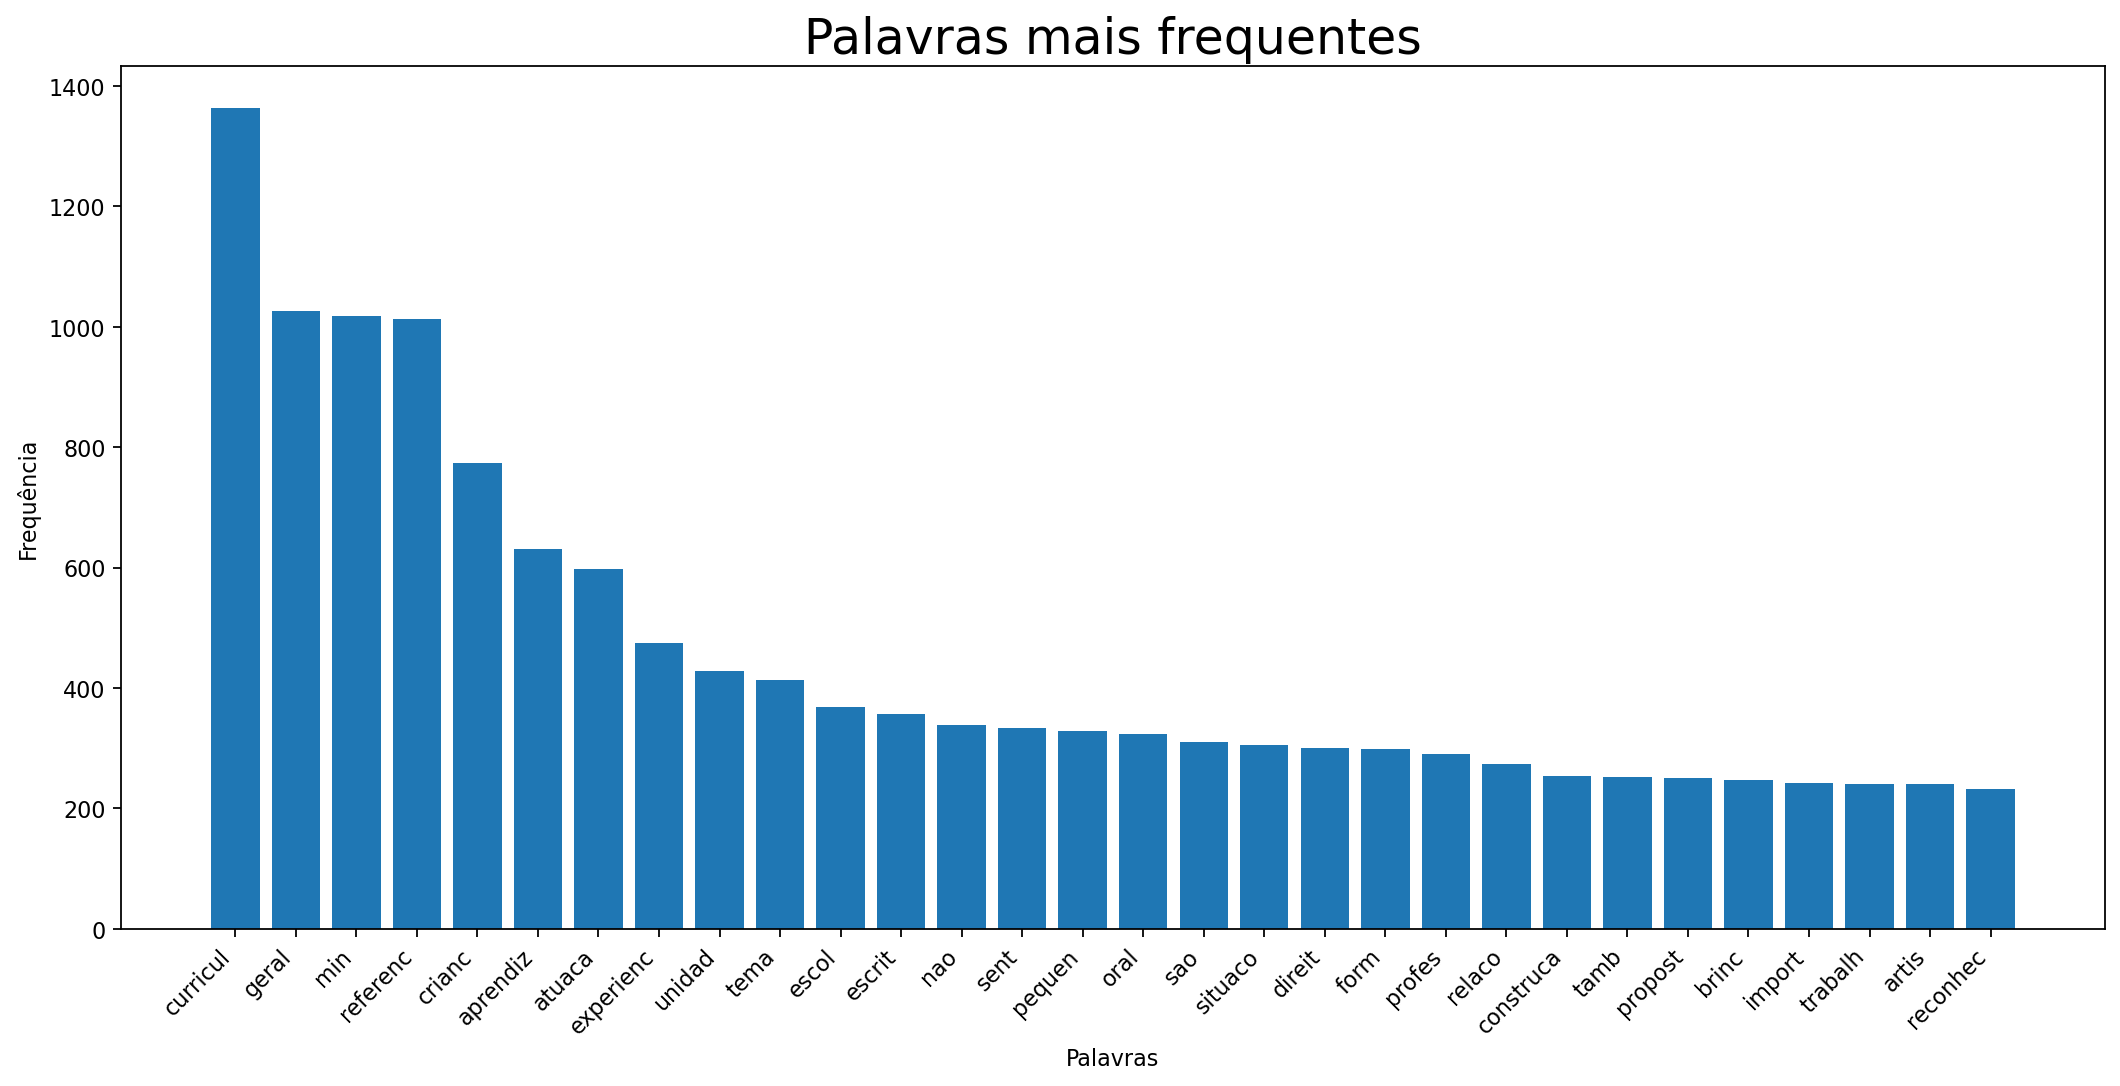

In [45]:
# Criar um gráfico de barras com as palavras mais frequentes:
plt.figure(figsize=(16,7), dpi=160)
plt.bar(top30_palavras_df['Palavra'], top30_palavras_df['Frequência'])
plt.title('Palavras mais frequentes', fontdict=dict(size=22))
plt.xlabel('Palavras')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequência')

# Salvar imagem:
plt.savefig('MG_2_Palavras mais frequentes.png')

plt.show()

### Nuvem de palavras para todo o documento:

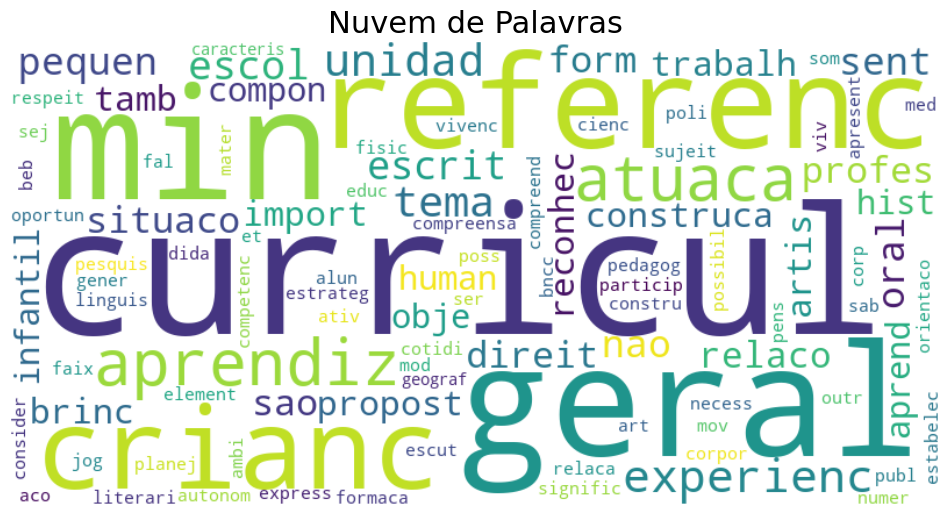

In [46]:
# Criar uma nuvem de palavras:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('MG_2_Nuvem de palavras_corpus.png')

plt.show()

### Frequência de palavras em cada tópico:

In [48]:
# Criar DataFrame com frequência das palavras no corpus e relevância no tópico:
topics = modelo_lda.show_topics(num_topics=num_topicos, formatted=False)
data_flat = [w for w_list in df['Stem'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_topicos = pd.DataFrame(out, columns=['Stem', 'topic_id', 'relevancia', 'frequencia'])

C:\Users\hugob\AppData\Local\Temp\ipykernel_18732\3188144919.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_18732\3188144919.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_18732\3188144919.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_18732\3188144919.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontal

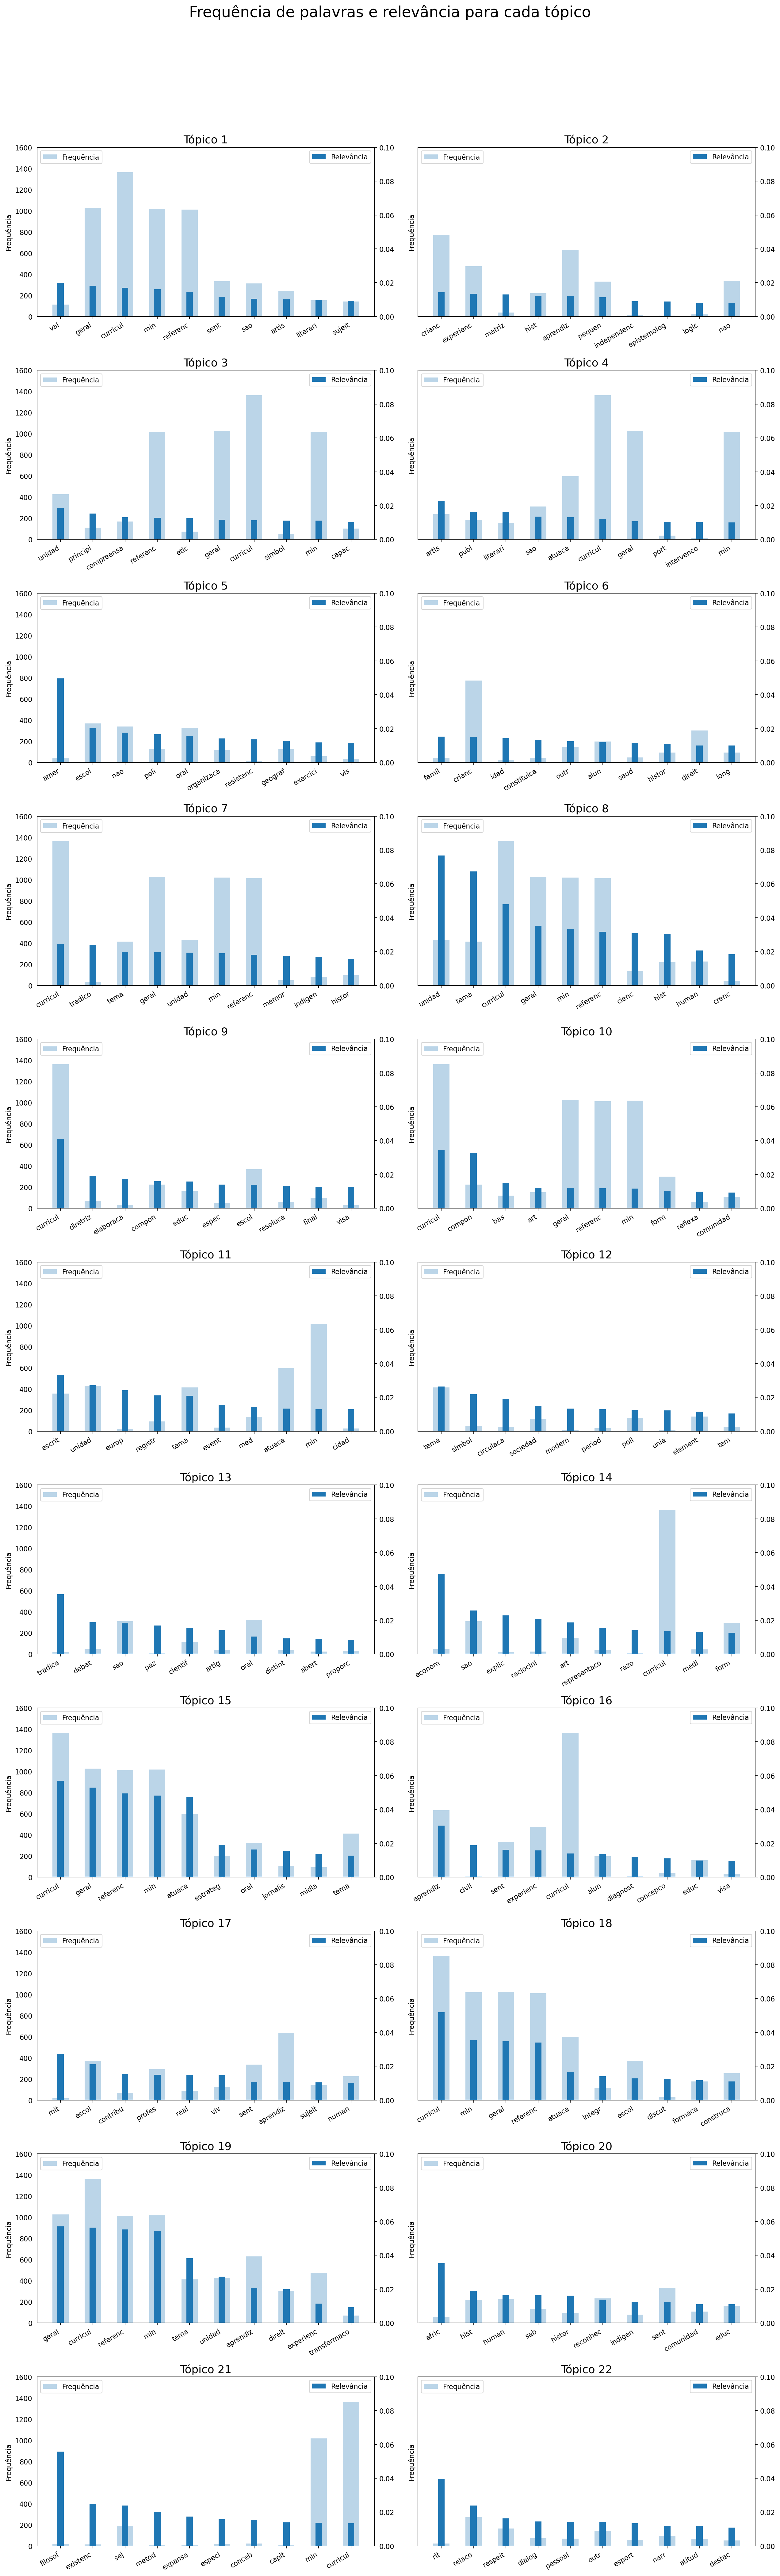

In [52]:
# Plotar contagem de palavras e pesos das palavras mais relevantes:
fig, axes = plt.subplots(11, 2, figsize=(16,50), sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Stem', height="frequencia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.5, alpha=0.3, label='Frequência')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Stem', height="relevancia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.2, label='Relevância')
    ax.set_ylabel('Frequência')
    ax_twin.set_ylim(0, 0.100); ax.set_ylim(0, 1600)
    ax.set_title('Tópico ' + str(i+1), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Frequência de palavras e relevância para cada tópico', fontsize=22, y=1.05)

# Salvar imagem:
plt.savefig('MG_2_Frequencia e relevancia de palavras por topico.png')

plt.show()

### Nuvem de palavras para cada tópico:

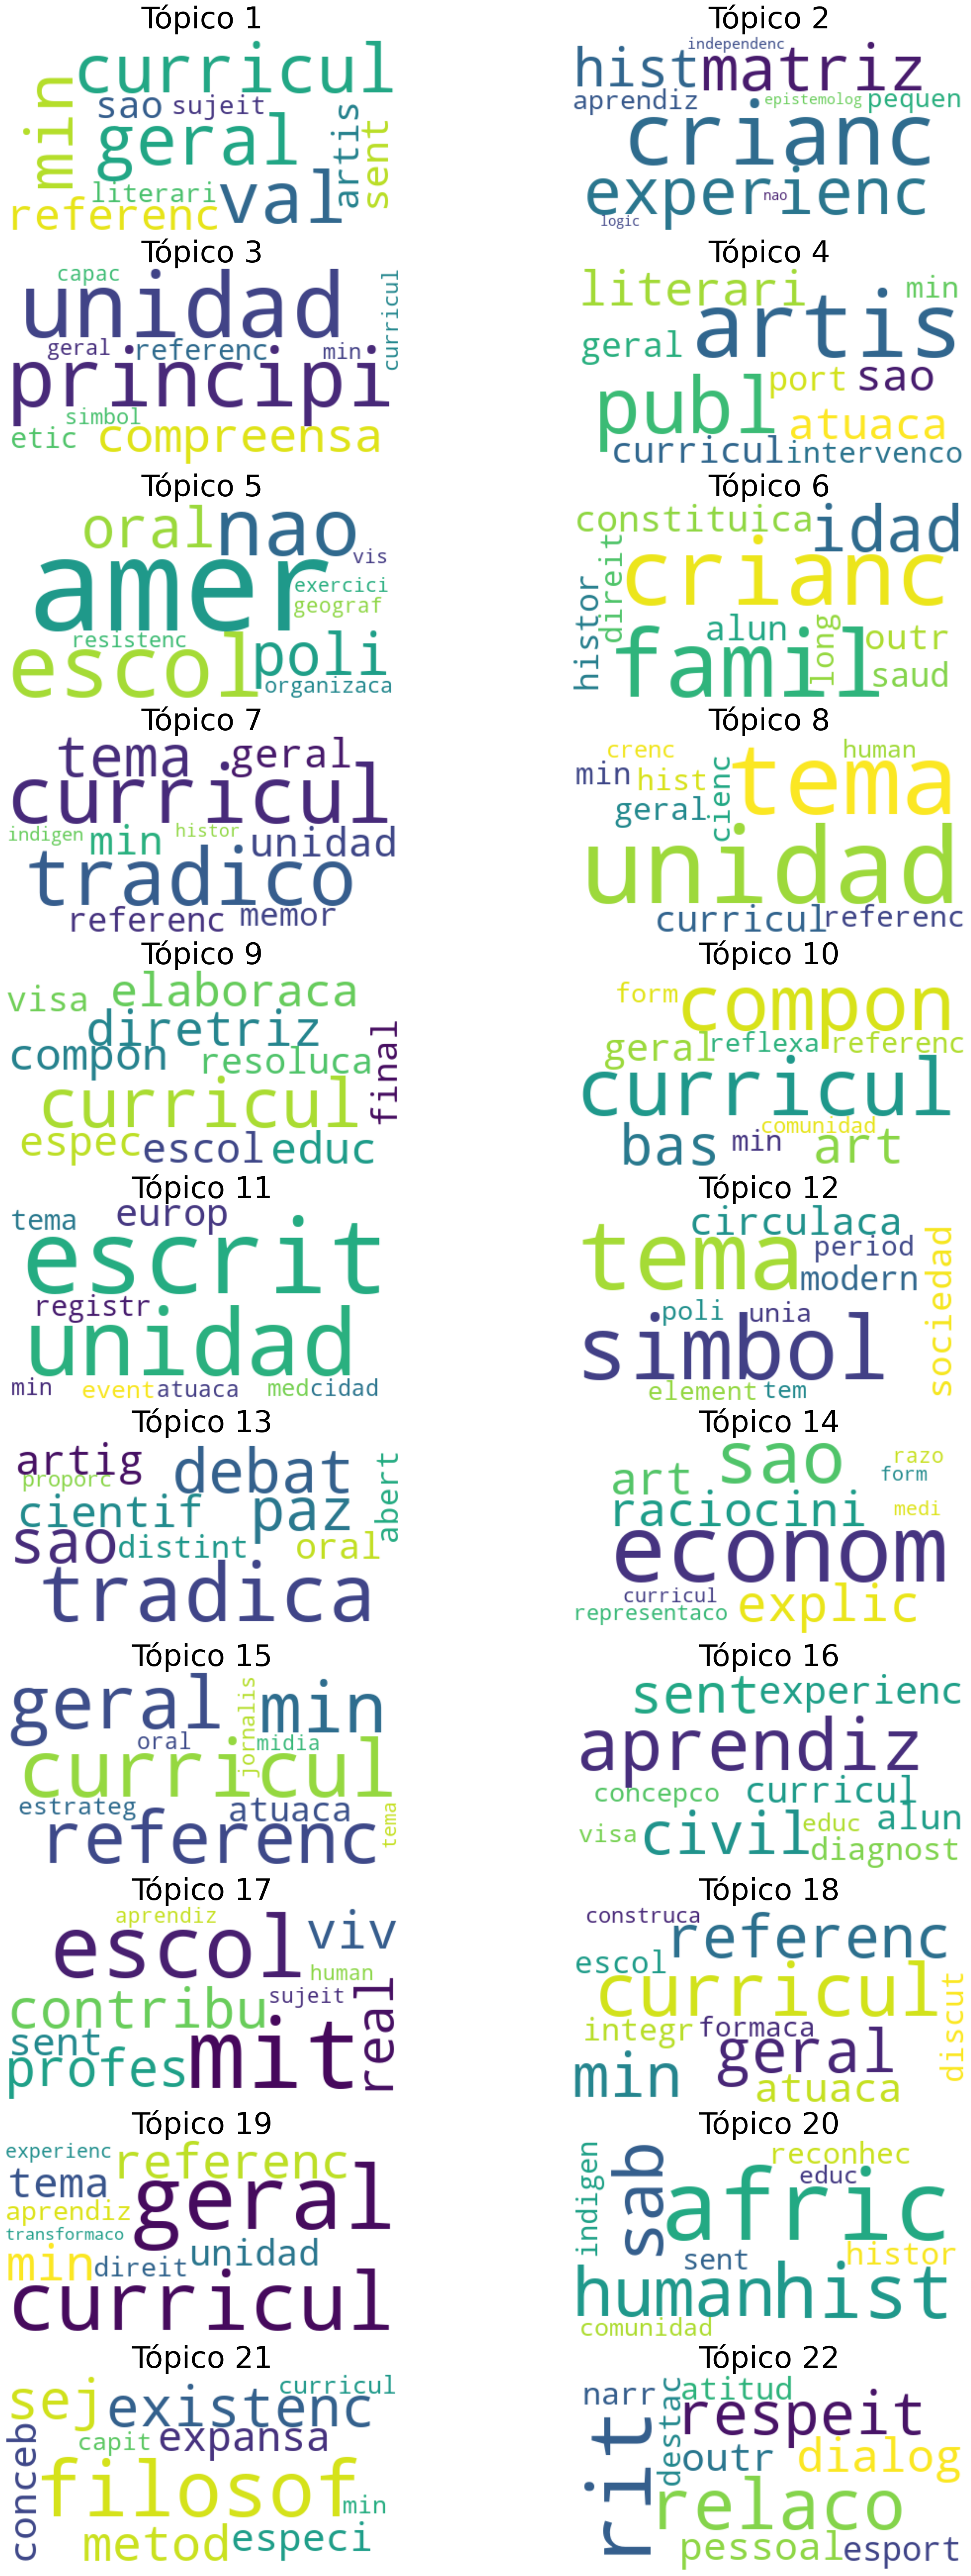

In [50]:
# Configuração do layout dos subplots
num_linhas = 11
num_colunas = 2

# Calcula o número total de subplots necessários
num_subplots = min(num_topicos, num_linhas * num_colunas)

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(30, 60)) 

for topico_id in range(num_subplots):
    # Obter as palavras e frequências associados ao tópico:
    topico_palavras_pesos = modelo_lda.show_topic(topico_id)
    
    # Criar um dicionário de contagem de palavras e pesos:
    contagem_palavras = {palavra: peso for palavra, peso in topico_palavras_pesos}
    
    # Criar o objeto WordCloud:
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(contagem_palavras)
    
    # Adicionar subplot ao layout
    linha = topico_id // num_colunas
    coluna = topico_id % num_colunas
    axs[linha, coluna].imshow(wordcloud, interpolation='bilinear')
    axs[linha, coluna].set_title(f'Tópico {topico_id + 1}', fontdict=dict(size=50))
    axs[linha, coluna].axis('off')

# Colocar o último subplot na última linha entre as duas colunas:
if num_topicos % num_colunas == 1:
    axs[-1, 0].axis('off')  # Desativa os eixos do último subplot na última linha
    axs[-1, 1].remove()     # Remove o último subplot na última linha, segunda coluna
    
# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Salvar imagem:
plt.savefig('MG_2_Nuvem de palavras por topico.png')

plt.show()